In [28]:
# Import dependencies and dataframe
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, accuracy_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

file_path = Path("./baseballdatabank-2022.2/HallofFameVariables.csv")
hof_df = pd.read_csv(file_path, index_col = 0)
hof_df.head()

,name,finalGame,eligible,votedBy,inducted,nominated,awardsGained,AGP,G_all,GS,...,PO,A,E,DP,PB,WP_y,SBF,CS,ZR,TP
playerID,,,,,,,,,,,,,,,,,,,,,
aardsda01,David Aardsma,2015-08-23,Y,Not voted,N,0.0,0.0,0.0,331.0,0.0,...,11.0,29.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
aaronha01,Hank Aaron,1976-10-03,Y,BBWAA,Y,1.0,16.0,24.0,3298.0,3173.0,...,7467.0,430.0,144.0,218.0,0.0,0.0,0.0,0.0,0.0,0.0
aaronto01,Tommie Aaron,1971-09-26,Y,Not voted,N,0.0,0.0,0.0,437.0,206.0,...,1317.0,113.0,22.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0
aasedo01,Don Aase,1990-10-03,Y,Not voted,N,0.0,0.0,1.0,448.0,91.0,...,67.0,136.0,13.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
abadan01,Andy Abad,2006-04-13,Y,Not voted,N,0.0,0.0,0.0,15.0,4.0,...,37.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [2]:
# Search for rows that have at least 1 null value.
for column in hof_df.columns:
    print(f"Column {column} has {hof_df[column].isnull().sum()} null values")

Column name has 0 null values
Column finalGame has 0 null values
Column eligible has 0 null values
Column votedBy has 0 null values
Column inducted has 0 null values
Column nominated has 0 null values
Column awardsGained has 0 null values
Column AGP has 0 null values
Column G_all has 0 null values
Column GS has 0 null values
Column G_batting has 0 null values
Column G_defense has 0 null values
Column G_p has 0 null values
Column G_c has 0 null values
Column G_1b has 0 null values
Column G_2b has 0 null values
Column G_3b has 0 null values
Column G_ss has 0 null values
Column G_lf has 0 null values
Column G_cf has 0 null values
Column G_rf has 0 null values
Column G_of has 0 null values
Column G_dh has 0 null values
Column G_ph has 0 null values
Column G_pr has 0 null values
Column AB has 0 null values
Column R has 0 null values
Column H has 0 null values
Column HR has 0 null values
Column RBI has 0 null values
Column SB has 0 null values
Column BB has 0 null values
Column IBB has 0 nul

In [3]:
# Drop the 'finalGame' column since it's not going to be used on the clustering algorithm.
hof_df.drop(columns=['finalGame', 'name'], inplace=True)
hof_df.head()

,eligible,votedBy,inducted,nominated,awardsGained,AGP,G_all,GS,G_batting,G_defense,...,PO,A,E,DP,PB,WP_y,SBF,CS,ZR,TP
playerID,,,,,,,,,,,,,,,,,,,,,
aardsda01,Y,Not voted,N,0.0,0.0,0.0,331.0,0.0,139.0,331.0,...,11.0,29.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
aaronha01,Y,BBWAA,Y,1.0,16.0,24.0,3298.0,3173.0,3298.0,2985.0,...,7467.0,430.0,144.0,218.0,0.0,0.0,0.0,0.0,0.0,0.0
aaronto01,Y,Not voted,N,0.0,0.0,0.0,437.0,206.0,437.0,346.0,...,1317.0,113.0,22.0,124.0,0.0,0.0,0.0,0.0,0.0,0.0
aasedo01,Y,Not voted,N,0.0,0.0,1.0,448.0,91.0,81.0,448.0,...,67.0,136.0,13.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
abadan01,Y,Not voted,N,0.0,0.0,0.0,15.0,4.0,15.0,9.0,...,37.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# binary encode votedby and eligibility
hof_binary_encoded = pd.get_dummies(hof_df, columns=["votedBy",'eligible'])
hof_binary_encoded.head()

,inducted,nominated,awardsGained,AGP,G_all,GS,G_batting,G_defense,G_p,G_c,...,votedBy_Final Ballot,votedBy_Negro League,votedBy_Nominating Vote,votedBy_Not voted,votedBy_Old Timers,votedBy_Run Off,votedBy_Special Election,votedBy_Veterans,eligible_N,eligible_Y
playerID,,,,,,,,,,,,,,,,,,,,,
aardsda01,N,0.0,0.0,0.0,331.0,0.0,139.0,331.0,331.0,0.0,...,0,0,0,1,0,0,0,0,0,1
aaronha01,Y,1.0,16.0,24.0,3298.0,3173.0,3298.0,2985.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
aaronto01,N,0.0,0.0,0.0,437.0,206.0,437.0,346.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
aasedo01,N,0.0,0.0,1.0,448.0,91.0,81.0,448.0,448.0,0.0,...,0,0,0,1,0,0,0,0,0,1
abadan01,N,0.0,0.0,0.0,15.0,4.0,15.0,9.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1


In [5]:
# Create our features
X = hof_df.drop('inducted', axis = 1)
X = pd.get_dummies(X)

# Create our target
y = hof_df['inducted']

In [6]:
X.describe()

,nominated,awardsGained,AGP,G_all,GS,G_batting,G_defense,G_p,G_c,G_1b,...,eligible_Y,votedBy_BBWAA,votedBy_Final Ballot,votedBy_Negro League,votedBy_Nominating Vote,votedBy_Not voted,votedBy_Old Timers,votedBy_Run Off,votedBy_Special Election,votedBy_Veterans
count,20166.000000,20166.000000,20166.000000,20166.000000,20166.000000,20166.000000,20166.000000,20166.000000,20166.000000,20166.000000,...,20166.000000,20166.000000,20166.000000,20166.000000,20166.000000,20166.000000,20166.000000,20166.000000,20166.000000,20166.000000
mean,0.200337,0.323812,0.210850,277.339383,184.161708,259.794059,233.918278,57.402658,25.313399,24.598582,...,0.878161,0.051721,0.000050,0.000149,0.000942,0.940444,0.001240,0.000397,0.000099,0.004959
std,1.305857,1.878395,1.036298,450.415982,393.182223,451.181877,402.737605,129.400069,140.813056,149.162511,...,0.327108,0.221468,0.007042,0.012196,0.030681,0.236668,0.035189,0.019914,0.009959,0.070246
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,14.000000,0.000000,9.000000,7.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,79.000000,15.000000,58.000000,55.500000,1.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,326.000000,150.000000,282.000000,269.000000,39.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,20.000000,47.000000,26.000000,3562.000000,3437.000000,3562.000000,3479.000000,1252.000000,2427.000000,2413.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
# Check the balance of our target values
y.value_counts()

N    19936
Y      230
Name: inducted, dtype: int64

In [8]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

# Random Forest 

In [9]:
# Creating a StandardScaler instance.
scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [10]:
# Resample the training data with the BalancedRandomForestClassifier
rf_hof = BalancedRandomForestClassifier(n_estimators=100, random_state = 1)

#Train the model using the training sets
rf_hof = rf_hof.fit(X_train_scaled, y_train)

# Making predictions using the testing data.
predictions = rf_hof.predict(X_test_scaled)

In [11]:
# Display the confusion matrix
matrix = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    matrix, index=["Actual N", "Actual Y"], columns=["Predicted N", "Predicted Y"])

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score :", balanced_accuracy_score(y_test, predictions))
print("Classification Report")
print(classification_report_imbalanced(y_test, predictions))

Confusion Matrix


,Predicted N,Predicted Y
Actual N,4736,248
Actual Y,0,58


Accuracy Score : 0.9751203852327448
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

          N       1.00      0.95      1.00      0.97      0.97      0.95      4984
          Y       0.19      1.00      0.95      0.32      0.97      0.95        58

avg / total       0.99      0.95      1.00      0.97      0.97      0.95      5042



In [24]:
# List the features sorted in descending order by feature importance
feature = sorted(zip(rf_hof.feature_importances_, X.columns), reverse=True)
feature

[(0.22748692195850886, 'nominated'),
 (0.13143731299400865, 'votedBy_Not voted'),
 (0.07962765950575612, 'G_all'),
 (0.06051361573093612, 'awardsGained'),
 (0.045178624570027366, 'G_batting'),
 (0.0401148709366019, 'H'),
 (0.03455786665335996, 'G_defense'),
 (0.034534537809563115, 'E'),
 (0.034264671683299844, 'AB'),
 (0.033622151326602345, 'RBI'),
 (0.03141149238996414, 'R'),
 (0.02513733315364997, 'A'),
 (0.018916930813400464, 'W'),
 (0.014542885783959682, 'PO'),
 (0.014291664246759594, 'batAVG'),
 (0.01265609749480581, 'BB'),
 (0.011921093445426995, 'G_p'),
 (0.011135395626436572, 'SB'),
 (0.010460859306613281, 'GS'),
 (0.00972785646097608, 'SH'),
 (0.00879805362757251, 'HBPB'),
 (0.008767958188288995, 'IPouts'),
 (0.008486367812705288, 'DP'),
 (0.006780814950075679, 'votedBy_BBWAA'),
 (0.006219481908524792, 'WP_x'),
 (0.005949259731168103, 'SO'),
 (0.00525428516874255, 'AGP'),
 (0.005214290633783494, 'ER'),
 (0.005141766965568768, 'BFP'),
 (0.004463988446566363, 'G_pr'),
 (0.004152

Text(0.5, 1.0, 'Feature importances')

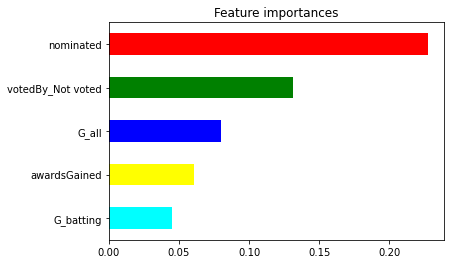

In [37]:
# Plot Importance
feat_importances = pd.Series(rf_hof.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh',color = ('red', 'green', 'blue', 'yellow', 'cyan')).invert_yaxis()
plt.title("Feature importances")

# Logistic Regression

In [39]:
# Resample the training data with the LogisticRegressionClassifier
classifier = LogisticRegression(solver='lbfgs',
   max_iter=200,
   random_state=1)
classifier

LogisticRegression(max_iter=200, random_state=1)

In [40]:
#Train the model using the training sets
classifier.fit(X_train, y_train)

# Making predictions using the testing data.
predictions = classifier.predict(X_test)

C:\Users\psode\anaconda3\envs\mlenv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(max_iter=200, random_state=1)

In [42]:
# Display the confusion matrix
matrix = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    matrix, index=["Actual N", "Actual Y"], columns=["Predicted N", "Predicted Y"])

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score :", balanced_accuracy_score(y_test, predictions))
print("Classification Report")
print(classification_report_imbalanced(y_test, predictions))

Confusion Matrix


,Predicted N,Predicted Y
Actual N,4941,43
Actual Y,32,26


Accuracy Score : 0.7198241268611281
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

          N       0.99      0.99      0.45      0.99      0.67      0.47      4984
          Y       0.38      0.45      0.99      0.41      0.67      0.42        58

avg / total       0.99      0.99      0.45      0.99      0.67      0.47      5042



# Support Vector Machine 

In [43]:
model = SVC(kernel='linear')

In [44]:
model.fit(X_train, y_train)

SVC(kernel='linear')

In [45]:
predictions = model.predict(X_test)
results = pd.DataFrame({
   "Prediction": predictions,
   "Actual": y_test
}).reset_index(drop=True)
results.head()

,Prediction,Actual
0,N,N
1,N,N
2,N,N
3,N,N
4,N,N


In [46]:
# Display the confusion matrix
matrix = confusion_matrix(y_test, predictions)

# Create a DataFrame from the confusion matrix.
cm_df = pd.DataFrame(
    matrix, index=["Actual N", "Actual Y"], columns=["Predicted N", "Predicted Y"])

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score :", balanced_accuracy_score(y_test, predictions))
print("Classification Report")
print(classification_report_imbalanced(y_test, predictions))

Confusion Matrix


,Predicted N,Predicted Y
Actual N,4967,17
Actual Y,14,44


Accuracy Score : 0.8776048873637017
Classification Report
                   pre       rec       spe        f1       geo       iba       sup

          N       1.00      1.00      0.76      1.00      0.87      0.77      4984
          Y       0.72      0.76      1.00      0.74      0.87      0.74        58

avg / total       0.99      0.99      0.76      0.99      0.87      0.77      5042

